In [0]:
#STAGE 0 - READING

#Upload csv file and read it.

import pandas as pd
#upload file
filepath = 'LA_AirBnB_Listings.csv'
LA_Airbnb = pd.read_csv(filepath)

In [0]:
#View the columns

LA_Airbnb.columns


In [0]:
# STAGE 1 - CLEANING - Dropping columns

#For the sake of our analysis, we do not need to know a few attributes, 
#such as 'is_location_exact', 'host_has_profile_pic' and 'host_listings_count' and 'host_acceptance_rate'
#So, let's drop them

LA_Airbnb = LA_Airbnb.drop(columns=['host_listings_count','host_has_profile_pic','is_location_exact', 'host_acceptance_rate'])

In [0]:
#Let us check if the columns have been dropped

LA_Airbnb.columns

In [0]:
# CLEANING - Does rating have null values? (Because our analysis in centered around rating)

LA_Airbnb['review_scores_rating']

In [0]:
#Drop null values from rating

LA_Airbnb = LA_Airbnb.dropna(subset=['review_scores_rating'])

In [0]:
#Check if nulls have been dropped from ratings

LA_Airbnb['review_scores_rating']

In [0]:
#Filter all rows with a rating >=90. Print and check number of rows.

LA_90s = LA_Airbnb[LA_Airbnb['review_scores_rating']>=90]
print(LA_90s.head())
print(LA_90s.shape)

In [0]:
#Among the ratings greater than 90, what is the distribution like?
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings

fig, ax = plt.subplots(2,1)

sns.distplot(LA_90s['review_scores_rating'], ax=ax[0]);
sns.distplot(LA_90s['review_scores_rating'], kde=False, bins=10, color='r', ax=ax[1]);

CONCLUSION: Most Airbnbs with a rating greater than 90 have been given a 100 rating.

In [0]:
#STAGE 2 - BASIC ANALYSIS
#Some analysis on importance of basic Airbnb characteristics

#How many owners who were rated above 90 had a strict, flexible or moderate cancellation policy?
print('Flexible: ' + str(round((LA_90s[LA_90s['cancellation_policy'] == 'flexible'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')
print('Moderate: ' + str(round((LA_90s[LA_90s['cancellation_policy'] == 'moderate'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')
print('Strict: ' + str(round((LA_90s[LA_90s['cancellation_policy'] == 'strict'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')

In [0]:
#Plot for better understanding

ax = sns.catplot(y="cancellation_policy", kind="count", data=LA_90s, height=2.6, aspect=2.5)

CONCLUSION - Surprisingly, owners rated greater than 90 mostly have a 'strict' cancellation policy although the assumption is that customers do not like strict policies. But, we can also see that none of them have a 'Super strict' policy.

In [23]:
#How many hosts are superhosts?

print('Superhost: ' + str(round((LA_90s[LA_90s['host_is_superhost'] == 't'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')
print('Not a superhost: ' + str(round((LA_90s[LA_90s['host_is_superhost'] == 'f'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')

Superhost: 29.82%
Not a superhost: 70.15%


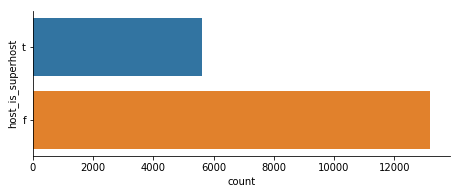

In [24]:
#Plot for better understanding

ax = sns.catplot(y="host_is_superhost", kind="count", data=LA_90s, height=2.6, aspect=2.5)

CONCLUSION - Again, surprisingly enough, apparently it doesn't take a host to be a superhost to get a rating above 90.

In [25]:
#How important is being instantly bookable for a rating greater than 90?

print('Instantly bookable: ' + str(round((LA_90s[LA_90s['instant_bookable'] == 't'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')
print('Not instantly bookable: ' + str(round((LA_90s[LA_90s['instant_bookable'] == 'f'].shape[0] / LA_90s.shape[0] * 100),2)) + '%')

Instantly bookable: 25.69%
Not instantly bookable: 74.31%


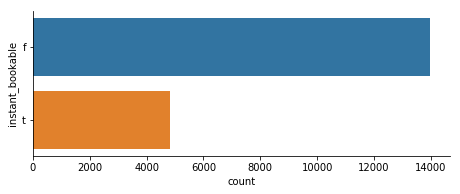

In [26]:
#Plot for better understanding

ax = sns.catplot(y="instant_bookable", kind="count", data=LA_90s, height=2.6, aspect=2.5)

CONCLUSION - Clearly, it is not necessary for an Airbnb to be instantly bookable to have a great rating. All our initial assumptions have been proven wrong. 

In [0]:
#STAGE 3 - DEEPER ANALYSIS
#So what affects a good rating? How do we know what a customer wants?

#Let us try to convert "Price" from float to string
#Remove the dollar sign
LA_90s['price'] = LA_90s['price'].str[1:]

In [0]:
#Replace all commas with "" and convert to float
LA_90s['price'] = LA_90s['price'].str.replace(",","")
LA_90s['price'] = LA_90s['price'].astype(float)

In [0]:
#We now see that "Price" is a float value
LA_90s['price']

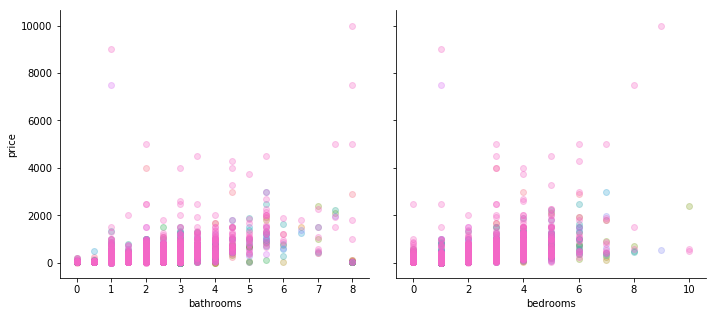

In [21]:
#Understand the effect of price and number of bedrooms/bathrooms on rating
g = sns.PairGrid(LA_90s, y_vars=["price"], x_vars=["bathrooms", "bedrooms"], height=4.5, hue="review_scores_rating", aspect=1.1)
ax = g.map(plt.scatter, alpha=0.3)


CONCLUSION: No significant corelation between price and number of bedrooms except a place with many bedrooms would obviously be priced highly.

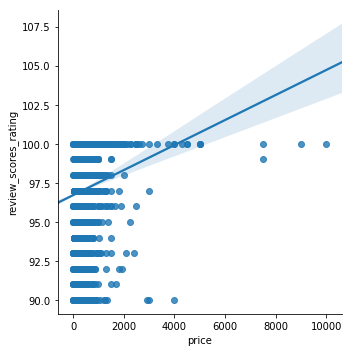

In [22]:
#To understand if increase in price increases rating
sns.lmplot(x="price", y="review_scores_rating", data=LA_90s);

CONCLUSION: The price of an Airbnb and its rating does not seem corelated until the price is much higher. This would imply that a pricier place is more likely to offer ameneties and services that would get a better rating. 

REGRESSION

In [0]:
#STAGE 4- REGRESSION
#Preprocessing - dropping values - Let us create a new dataset with values that would matter to the regression.

LA_90_Reg = LA_90s.drop(columns=['street','city','host_neighbourhood', 'security_deposit', 'cleaning_fee', 'property_type', 'bed_type', 'room_type', 'host_total_listings_count', 'host_response_time', 'host_response_rate', 'state', 'zipcode', 'market', 'smart_location', 'accommodates', 'beds', 'amenities', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'first_review', 'last_review', 'instant_bookable', 'reviews_per_month'])
LA_90_Reg.info()

In [0]:
#Preprocessing - categorical values
LA_90_Reg_dum = pd.get_dummies(LA_90_Reg, columns=['host_is_superhost', 'host_identity_verified', 'cancellation_policy'])
LA_90_Reg_dum.head()
LA_90_Reg_dum.columns

In [0]:
LA_90_Reg_dum.drop(['host_is_superhost_f', 'host_identity_verified_f', 'cancellation_policy_super_strict_60'], axis=1, inplace=True)
LA_90_Reg_dum.info()

In [0]:
#Replace all Nan (for floats) with Zero

LA_90_Reg_dum['bathrooms'].fillna(0, inplace=True)
LA_90_Reg_dum['bedrooms'].fillna(0, inplace=True)
LA_90_Reg_dum['price'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_rating'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_accuracy'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_cleanliness'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_checkin'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_communication'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_location'].fillna(0, inplace=True)
LA_90_Reg_dum['review_scores_value'].fillna(0, inplace=True)

In [0]:

#Our target variable is "review_scores_rating", and so we are dropping it in X

X = LA_90_Reg_dum.drop('review_scores_rating', axis=1)
X.shape

In [0]:
#Target variable Y contains "review_scores_rating"

y = LA_90s['review_scores_rating']
y.shape

In [0]:
#Split train and test
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=833)

In [0]:
#Import linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [0]:
#Fit the model with train data
model.fit(Xtrain, ytrain)

In [0]:
#Print model coeffs
print("Model coefficients:    ", model.coef_)
print("Model intercept:", model.intercept_)

In [0]:
y_model = model.predict(Xtest)

In [0]:
test = Xtest.join(ytest).reset_index()
test.join(pd.Series(y_model, name='predicted')).head()

In [0]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, y_model)